# Neural Machine Translation

- will build NMT model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25")
- using an attention model (sequence-to-sequence) model

In [1]:
import numpy as np
import random
from faker import Faker
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt

# Modern Keras imports
from tensorflow.keras.layers import (
    Bidirectional,
    Concatenate,
    Dot,
    Input,
    LSTM,
    Multiply,
    RepeatVector,
    Dense,
    Activation,
    Lambda,
    Permute,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

# If you have nmt_utils locally
from nmt_utils import *

# Jupyter magic — must be on its own line
%matplotlib inline


## 1. Translating human readable dates into machine readable dates

>You’re training a simplified seq2seq model that converts messy, human-formatted dates into a standardized **YYYY-MM-DD** format, acting as a lightweight stand-in for real language translation.


### 1.1 Dataset

on a dataset of 10,000 human readable dates and their equivalent machine readable dates.


In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)


100%|██████████| 10000/10000 [00:00<00:00, 17987.44it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('friday october 24 2025', '2025-10-24'),
 ('monday august 19 2024', '2024-08-19'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('07 mar 1983', '1983-03-07'),
 ('22 may 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08')]

In [ ]:
Tx = 30 # max. length of human readable date.
Ty = 10 # as output would be of 10 length of Date format.
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape) # one-hot versions
print("Yoh.shape:", Yoh.shape)



X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
# preprocessed dataset
index = 34
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: wednesday december 5 2018
Target date: 2018-12-05

Source after preprocessing (indices): [33 17 16 25 17 29 16 13 34  0 16 17 15 17 24 14 17 28  0  8  0  5  3  4
 11 36 36 36 36 36]
Target after preprocessing (indices): [3 1 2 9 0 2 3 0 1 6]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


## 2. Neural machine translation with attention

### 2.1 Attention mechanism


You run a Bi-LSTM over the input date to get hidden states.
For each output timestep, attention compares the decoder’s previous hidden state with every encoder state to produce weights.
These weights create a context vector — a weighted sum of encoder states — fed into the decoder LSTM to generate the next character in the normalized date format.


You need to build `one_step_attention()` so that every decoder timestep uses the **same** attention layers.
Therefore, define the attention layers **globally**, not inside the function, and reuse them each timestep.
Use `RepeatVector`, `Concatenate`, `Dense`, `Activation`, and `Dot` exactly as provided — the grader checks their names.



In [7]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation='tanh')
densor2 = Dense(1, activation='relu')
activator = Activation(softmax, name='attention_weights') # using a custom softmax func.add_loss
dotor = Dot(axes = 1)

In [8]:
def one_step_attention(a, s_prev):

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" 
    s_prev = repeator(s_prev)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. 
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" 
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell 
    context = dotor([alphas, a])

    return context

In [10]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"
post__activation_LSTM_cell = LSTM(n_s, return_state=True)
output_layer = Dense(len(machine_vocab), activation=softmax)


In [11]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):

    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0 # hiddne state
    c = c0 # cell state
    outputs = [] # empty list to carry out each iteration in for loop

    a = Bidirectional(LSTM(n_a, return_sequences=True))(X) # pre-attention Bi-LSTM
    for t in range(Ty):
        context = one_step_attention(a, s) # get the context vector
        s, _, c = post__activation_LSTM_cell(context, initial_state=[s, c]) # post attention LSTM cell
        out = output_layer(s)
        outputs.append(out)

    model = Model(inputs=[X, s0, c0], outputs=outputs)

    return model




In [12]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [14]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ lstm_1[1][0],     │
│                     │                   │            │ lstm_1[2][0],     │
│                     │                   │            │ lstm_1[3][0],     │
│                     │                   │            │ lstm_1[4][0],     │
│                     │                   │            │ lstm_1[5][0],     │
│                     │                   │            │ lstm_1[6][0],     │
│                     │                   │            │ lstm_1[7][0],     │
│                     │                   │            │ lstm_1[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 10)    │      1,290 │ concatenate_1[0]… │
│                     │                   │            │ concatenate_1[1]… │
│                     │                   │            │ concatenate_1[2]… │
│                     │                   │            │ concatenate_1[3]… │
│                     │                   │            │ concatenate_1[4]… │
│                     │                   │            │ concatenate_1[5]… │
│                     │                   │            │ concatenate_1[6]… │
│                     │                   │            │ concatenate_1[7]… │
│                     │                   │            │ concatenate_1[8]

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)


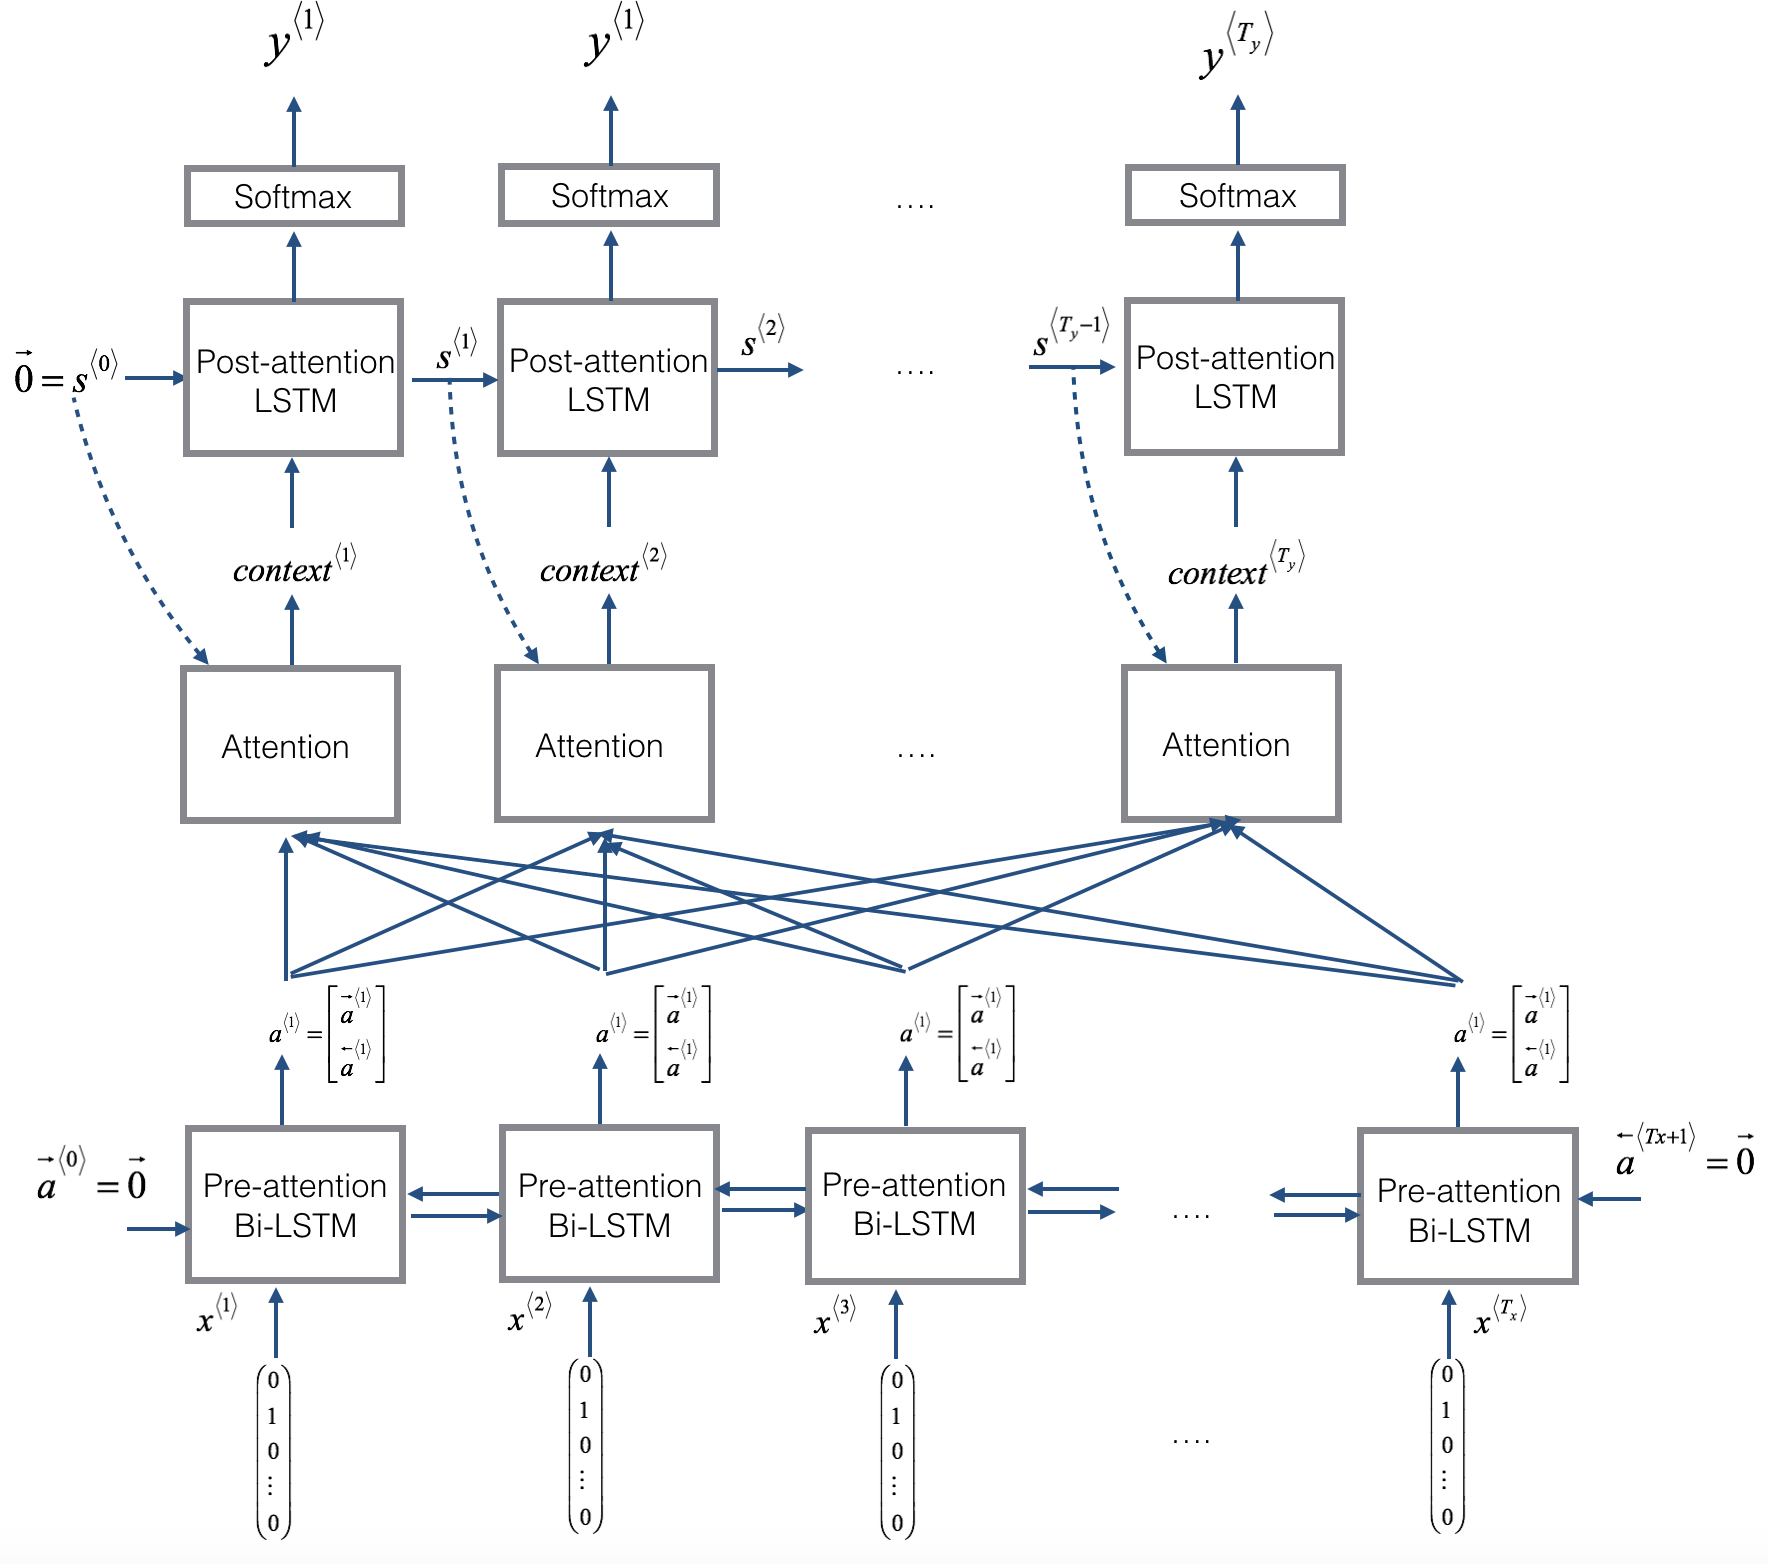

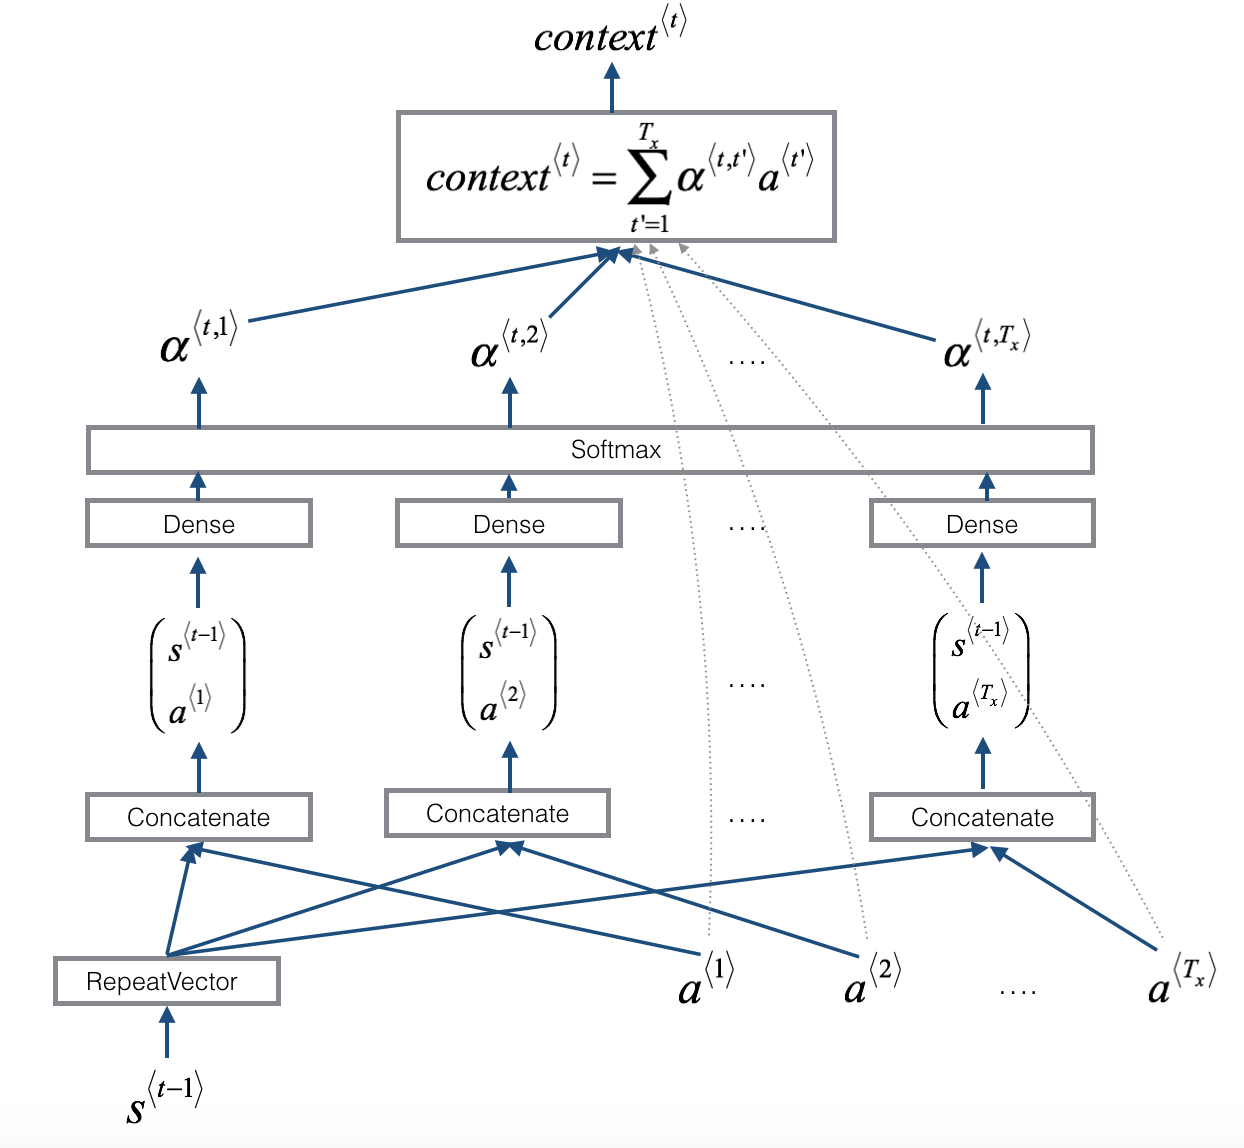

#### Compile the model


In [18]:
opt=  Adam(learning_rate=0.005, beta_1 = 0.9, beta_2 = 0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']*Ty)

c:\python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [19]:
# inputs, outputs and fit the model
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0, 1))

In [20]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - dense_5_accuracy: 0.3021 - dense_5_accuracy_1: 0.6530 - dense_5_accuracy_2: 0.2543 - dense_5_accuracy_3: 0.0797 - dense_5_accuracy_4: 0.7606 - dense_5_accuracy_5: 0.2432 - dense_5_accuracy_6: 0.0360 - dense_5_accuracy_7: 0.7896 - dense_5_accuracy_8: 0.1937 - dense_5_accuracy_9: 0.0796 - dense_5_loss: 2.6760 - loss: 19.2384


- loading the weights of already trained one to save some time

In [21]:
model.load_weights('models/model.h5')

In [23]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(source)
    source = to_categorical(source, num_classes=len(human_vocab))
    source = source.reshape((1, Tx, len(human_vocab)))  # <-- IMPORTANT
    s0_pred = np.zeros((1, n_s))
    c0_pred = np.zeros((1, n_s))
    prediction = model.predict([source, s0_pred, c0_pred])
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(i)] for  i in prediction]

    print("source:", example)
    print("output:", ''.join(output),"\n")




1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
source: 3 May 1979
output: 1979-05-33 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
source: 5 April 09
output: 2009-04-05 



C:\Users\Naman chanana\AppData\Local\Temp\ipykernel_4152\3134789508.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output = [inv_machine_vocab[int(i)] for  i in prediction]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
source: 21th of August 2016
output: 2016-08-20 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
source: March 3 2001
output: 2001-03-03 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
source: 1 March 2001
output: 2001-03-01 



## 3. Visualizing Attention

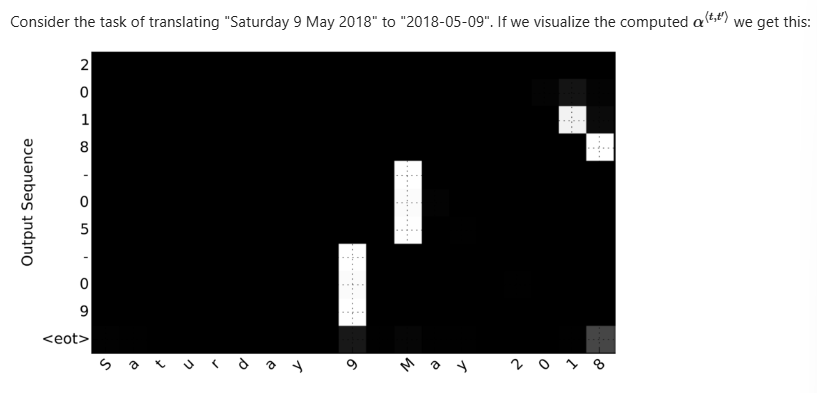


- Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We also see that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018."


#### 3.1 Getting the attention weights from the network

- to visualize the attention values in my network.

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ lstm_1[1][0],     │
│                     │                   │            │ lstm_1[2][0],     │
│                     │                   │            │ lstm_1[3][0],     │
│                     │                   │            │ lstm_1[4][0],     │
│                     │                   │            │ lstm_1[5][0],     │
│                     │                   │            │ lstm_1[6][0],     │
│                     │                   │            │ lstm_1[7][0],     │
│                     │                   │            │ lstm_1[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 10)    │      1,290 │ concatenate_1[0]… │
│                     │                   │            │ concatenate_1[1]… │
│                     │                   │            │ concatenate_1[2]… │
│                     │                   │            │ concatenate_1[3]… │
│                     │                   │            │ concatenate_1[4]… │
│                     │                   │            │ concatenate_1[5]… │
│                     │                   │            │ concatenate_1[6]… │
│                     │                   │            │ concatenate_1[7]… │
│                     │                   │            │ concatenate_1[8]

 Total params: 158,882 (620.64 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,922 (413.76 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<Figure size 640x480 with 0 Axes>

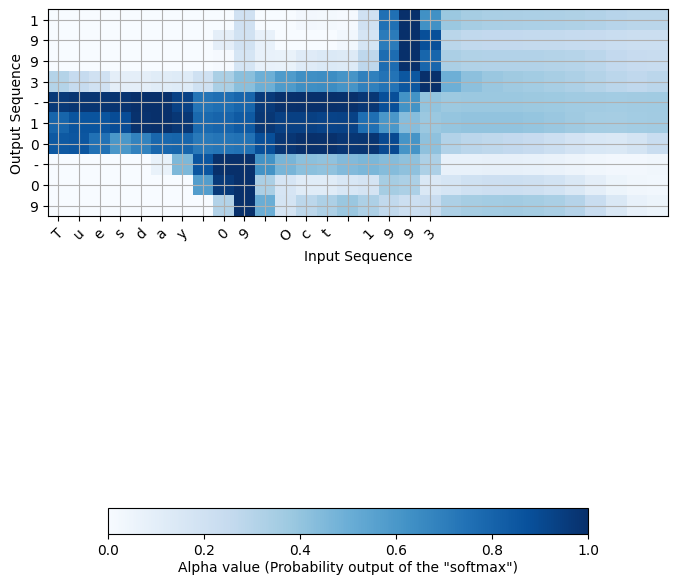

In [25]:
# pulling out the attention values from the model and plot them.
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num=7, n_s = 64)

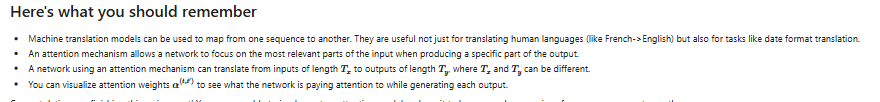

# Finish.